# In-class notebook: 2025-01-06

In this notebook, we will get familiar with the basics function related to downloading SDSS data using astroML, some basic plotting techniques. We will then switch gear to talk a little about common speed-up strategies in sorting and searching.

This notebook is intended to support Chapter 1-2 of the textbook, and material is taken from the following scripts (from astroML):
* https://github.com/astroML/astroML_figures/blob/main/book_figures/chapter1/fig_SDSS_imaging.py
* https://github.com/astroML/astroML_figures/blob/main/book_figures/chapter1/fig_sdss_S82standards.py
* https://github.com/astroML/astroML_figures/blob/main/book_figures/chapter1/fig_S82_scatter_contour.py
* https://github.com/astroML/astroML_figures/blob/main/book_figures/chapter1/fig_S82_hess.py
* https://github.com/astroML/astroML_figures/blob/main/book_figures/chapter1/fig_sdss_spectrum.py
* https://github.com/astroML/astroML_figures/blob/main/book_figures/chapter2/fig_search_scaling.py
* https://github.com/astroML/astroML_figures/blob/main/book_figures/chapter2/fig_sort_scaling.py
* https://github.com/astroML/astroML_figures/blob/main/book_figures/chapter2/fig_kdtree_example.py

In [1]:
# import basic stuff
import numpy as np
from matplotlib import pyplot as plt

Matplotlib is building the font cache; this may take a moment.


## Download the SDSS imaging data and make some plots

In [1]:
from astroML.datasets import fetch_imaging_sample

Nstars = 5000
Ngals = 5000

data = fetch_imaging_sample()
# fetch imaging data catalog (see https://github.com/astroML/astroML/blob/main/astroML/datasets/imaging_sample.py)
# you can learn more about SQL queries in the book's appendix
# check where the files were downloaded? 

print('total object counts', len(data))

# object type 6 is stars and 3 is galaxies
objtype = data['type']
stars = data[objtype == 6][:Nstars]
galaxies = data[objtype == 3][:Ngals]

total object counts 330753


In [4]:
# print the column names for both stars and galaxies
print(stars.dtype.names)

('ra', 'dec', 'run', 'rExtSFD', 'uRaw', 'gRaw', 'rRaw', 'iRaw', 'zRaw', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'uRawPSF', 'gRawPSF', 'rRawPSF', 'iRawPSF', 'zRawPSF', 'upsfErr', 'gpsfErr', 'rpsfErr', 'ipsfErr', 'zpsfErr', 'type', 'ISOLATED')


### Any idea what these columns are? 

You can read the schema to find out what is what - https://skyserver.sdss.org/dr7/en/help/browser/browser.asp

### Now plot

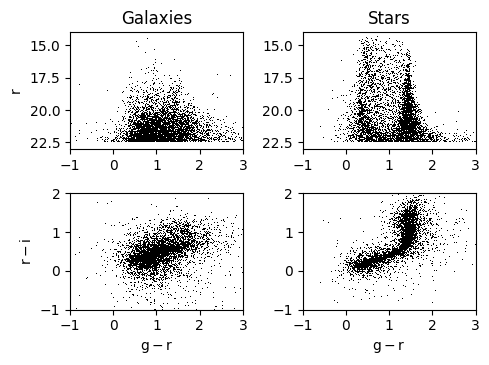

In [7]:
plot_kwargs = dict(color='k', linestyle='none', marker=',')

fig = plt.figure(figsize=(5, 3.75))

ax1 = fig.add_subplot(221)
ax1.plot(galaxies['gRaw'] - galaxies['rRaw'],
         galaxies['rRaw'],
         **plot_kwargs)

ax2 = fig.add_subplot(223, sharex=ax1)
ax2.plot(galaxies['gRaw'] - galaxies['rRaw'],
         galaxies['rRaw'] - galaxies['iRaw'],
         **plot_kwargs)

ax3 = fig.add_subplot(222, sharey=ax1)
ax3.plot(stars['gRaw'] - stars['rRaw'],
         stars['rRaw'],
         **plot_kwargs)

ax4 = fig.add_subplot(224, sharex=ax3, sharey=ax2)
ax4.plot(stars['gRaw'] - stars['rRaw'],
         stars['rRaw'] - stars['iRaw'],
         **plot_kwargs)

# set labels and titles
ax1.set_ylabel(r'${\rm r}$')
ax2.set_ylabel(r'${\rm r - i}$')
ax2.set_xlabel(r'${\rm g - r}$')
ax4.set_xlabel(r'${\rm g - r}$')
ax1.set_title('Galaxies')
ax3.set_title('Stars')

# set axis limits
ax2.set_xlim(-1, 3)
ax3.set_ylim(23.0, 14)
ax4.set_xlim(-1, 3)
ax4.set_ylim(-1, 2)

fig.tight_layout()


## Download a set of SDSS standard stars and plot its color-color diagram

In [9]:
from astroML.datasets import fetch_sdss_S82standards

# Fetch the stripe 82 data (see https://github.com/astroML/astroML/blob/main/astroML/datasets/sdss_S82standards.py)
data = fetch_sdss_S82standards()

# select the first 10000 points
data = data[:10000]

In [10]:
print(data.dtype.names)

('RA', 'DEC', 'RArms', 'DECrms', 'Ntot', 'A_r', 'Nobs_u', 'mmed_u', 'mmu_u', 'msig_u', 'mrms_u', 'mchi2_u', 'Nobs_g', 'mmed_g', 'mmu_g', 'msig_g', 'mrms_g', 'mchi2_g', 'Nobs_r', 'mmed_r', 'mmu_r', 'msig_r', 'mrms_r', 'mchi2_r', 'Nobs_i', 'mmed_i', 'mmu_i', 'msig_i', 'mrms_i', 'mchi2_i', 'Nobs_z', 'mmed_z', 'mmu_z', 'msig_z', 'mrms_z', 'mchi2_z')


In [11]:
# select the mean magnitudes for g, r, i
g = data['mmu_g']
r = data['mmu_r']
i = data['mmu_i']

### Plot

Text(0, 0.5, '${\\rm r - i}$')

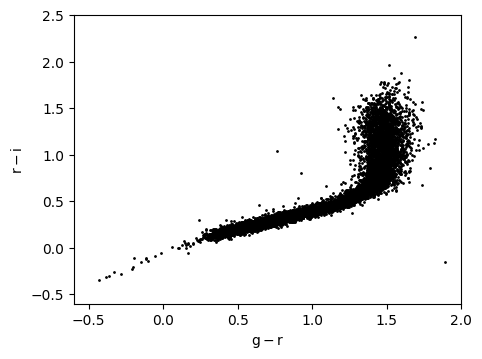

In [14]:
# Plot the g-r vs r-i colors
fig, ax = plt.subplots(figsize=(5, 3.75))
ax.plot(g - r, r - i, marker='.', markersize=2,
        color='black', linestyle='none')

ax.set_xlim(-0.6, 2.0)
ax.set_ylim(-0.6, 2.5)

ax.set_xlabel(r'${\rm g - r}$')
ax.set_ylabel(r'${\rm r - i}$')

### We can plot it differently, with more points: contours and Hess

In [15]:
# Fetch the stripe 82 data (see https://github.com/astroML/astroML/blob/main/astroML/datasets/sdss_S82standards.py)
data = fetch_sdss_S82standards()

# select the mean magnitudes for g, r, i
g = data['mmu_g']
r = data['mmu_r']
i = data['mmu_i']

In [16]:
from astroML.plotting import scatter_contour

fig, ax = plt.subplots(figsize=(5, 3.75))
scatter_contour(g - r, r - i, threshold=200, log_counts=True, ax=ax,
                histogram2d_args=dict(bins=40),
                plot_args=dict(marker=',', linestyle='none', color='black'),
                contour_args=dict(cmap=plt.cm.bone))

ax.set_xlabel(r'${\rm g - r}$')
ax.set_ylabel(r'${\rm r - i}$')

ax.set_xlim(-0.6, 2.5)
ax.set_ylim(-0.6, 2.5)


/opt/anaconda3/lib/python3.11/site-packages/theano/scalar/basic.py:2412: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  self.ctor = getattr(np, o_type.dtype)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

(-0.6, 2.5)

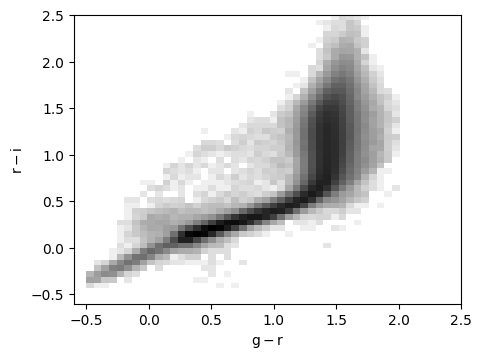

In [18]:
import copy

# Compute and plot the 2D histogram
H, xbins, ybins = np.histogram2d(g - r, r - i,
                                 bins=(np.linspace(-0.5, 2.5, 50),
                                       np.linspace(-0.5, 2.5, 50)))

# Use the image display function imshow() to plot the result
fig, ax = plt.subplots(figsize=(5, 3.75))
H[H == 0] = 1  # prevent warnings in log10

ax.imshow(np.log10(H).T, origin='lower',
          extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
          cmap='binary', interpolation='nearest',
          aspect='auto')

ax.set_xlabel(r'${\rm g - r}$')
ax.set_ylabel(r'${\rm r - i}$')

ax.set_xlim(-0.6, 2.5)
ax.set_ylim(-0.6, 2.5)

## We can also download SDSS spectra and plot them

In [28]:
from astroML.datasets import fetch_sdss_spectrum

# Fetch single spectrum
plate = 1615
mjd = 53166
fiber = 513

spec = fetch_sdss_spectrum(plate, mjd, fiber)

#------------------------------------------------------------
# Plot the resulting spectrum
ax = plt.axes()
ax.plot(spec.wavelength(), spec.spectrum, '-k', label='spectrum')
ax.plot(spec.wavelength(), spec.error, '-', color='gray', label='error')

ax.legend(loc=4)

ax.set_title('Plate = %(plate)i, MJD = %(mjd)i, Fiber = %(fiber)i' % locals())

ax.text(0.05, 0.95, 'z = %.2f' % spec.z, size=16,
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$\lambda (\AA)$')
ax.set_ylabel('Flux')

ax.set_ylim(-10, 300)

plt.show()

KeyError: 'Content-Length'

## Next we will talk about strategies to speed up some common operations

### Sorting: numpy quick-sort and python list sort

In [ ]:
np.random.seed(0)
X = np.random.rand(10000000)
print(X)

In [ ]:
%time X.sort()

In [ ]:
# note that a pre-sorted array sorts faster!
%time X.sort()

In [ ]:
print(X)

### Compare two types of sorting

In [ ]:
from time import time

# time quick-sort of a numpy array
N_npy = 10 ** np.linspace(5, 7, 10)
time_npy = np.zeros_like(N_npy)

for i in range(len(N_npy)):
    x = np.random.random(int(N_npy[i]))
    t0 = time()
    x.sort()
    t1 = time()
    time_npy[i] = t1 - t0

# time built-in sort of python list
N_list = N_npy.copy()
time_list = np.zeros_like(N_list)

for i in range(len(N_list)):
    x = list(np.random.random(int(N_list[i])))
    t0 = time()
    x.sort()
    t1 = time()
    time_list[i] = t1 - t0


In [ ]:
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(bottom=0.15)
ax = plt.axes(xscale='log', yscale='log')
ax.grid()

# plot the observed times
ax.plot(N_list, time_list, 'sk', color='gray', ms=5, label='list sort')
ax.plot(N_npy, time_npy, 'ok', color='gray', ms=5, label='NumPy sort')

# plot the expected scalings
scale = np.linspace(N_npy[0] / 2, N_npy[-1] * 2, 100)
scaling_N = scale * time_npy[0] / N_npy[0]
scaling_NlogN = (scale * np.log2(scale) 
                 * time_npy[0] / N_npy[0] / np.log2(N_npy[0]))

ax.plot(scale, scaling_NlogN, '--k', label=r'$\mathcal{O}[N \log N]$')
ax.plot(scale, scaling_N, ':k', label=r'$\mathcal{O}[N]$')

scaling_N = scale * time_list[0] / N_list[0]
scaling_NlogN = (scale * np.log2(scale) * time_list[0]
                 / N_list[0] / np.log2(N_list[0]))

ax.plot(scale, scaling_NlogN, '--k')
ax.plot(scale, scaling_N, ':k')

# Create titles and labels
ax.set_title("Scaling of Sort Algorithms")
ax.set_xlabel('Length of Array')
ax.set_ylabel('Relative sort time')
plt.legend(loc='upper left')

ax.set_xlim(scale[0], scale[-1])

### Searching: linear search and binary search in an ordered list 

In [ ]:
# Compute the execution times as a function of array size
Nsamples = 10 ** np.linspace(6.0, 7.8, 17)
time_linear = np.zeros_like(Nsamples)
time_binary = np.zeros_like(Nsamples)

for i in range(len(Nsamples)):
    # create a sorted array
    x = np.arange(Nsamples[i], dtype=int)

    # Linear search: choose a single item in the array
    item = int(0.4 * Nsamples[i])

    t0 = time()
    j = np.where(x == item)
    t1 = time()

    time_linear[i] = t1 - t0

    # Binary search: this is much faster, so choose 1000 items to search for
    items = np.linspace(0, Nsamples[i], 1000).astype(int)

    t0 = time()
    j = np.searchsorted(x, items)
    t1 = time()

    time_binary[i] = (t1 - t0)

In [ ]:
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(bottom=0.15)
ax = plt.axes(xscale='log', yscale='log')
ax.grid()

# plot the observed times
ax.plot(Nsamples, time_linear, 'o', color='gray', markersize=5,
        label=r'linear search $(\mathcal{O}[N])$')
ax.plot(Nsamples, time_binary, 's', color='gray', markersize=5,
        label=r'efficient search $(\mathcal{O}[\log N])$')

# plot the expected scaling
scale = 10 ** np.linspace(5, 8, 100)
scaling_N = scale * time_linear[7] / Nsamples[7]
scaling_logN = np.log(scale) * time_binary[7] / np.log(Nsamples[7])
ax.plot(scale, scaling_N, '--k')
ax.plot(scale, scaling_logN, '--k')

ax.set_xlim(9E5, 1E8)

# add text and labels
ax.set_title("Scaling of Search Algorithms")
ax.set_xlabel('Length of Array')
ax.set_ylabel('Relative search time')
ax.legend(loc='upper left')

### Searching: nearest-neighbor search

We want to find the nearest point in an array X within the array.

In [ ]:
# we look at two strategies

def easy_nn(X):
    N, D = X.shape
    neighbors = np.zeros(N, dtype=int)
    for i in range(N):
        j_closest = i
        d_closest = np.inf # initialize closest distance to infinity
        for j in range(N):
            if i==j:
                continue
            d = np.sqrt(np.sum((X[i] - X[j])**2))
            if d < d_closest:
                j_closest = j 
                d_closest = d
        neighbors[i] = j_closest
    return neighbors

def vectorized_nn(X):
    XXT = np.dot(X, X.T)
    Xii = XXT.diagonal()
    D = np.sqrt(Xii - 2* XXT + Xii[:, np.newaxis])
    return np.argsort(D, axis=1)[:,1] # first element is 0

In [ ]:
X = np.random.random((10,3))
print(X)

In [ ]:
easy_nn(X)

In [ ]:
vectorized_nn(X)

In [ ]:
%timeit easy_nn(X)

In [ ]:
%timeit vectorized_nn(X)

In [ ]:
X = np.random.random((1000,3))

%timeit easy_nn(X)

%timeit vectorized_nn(X)

### Finally, let's look at the idea of "trees"

Assume we have a similar problem where we want to look for nearest neighbors in an array X.

In [ ]:
X = np.random.random((10,3))
print(X)

In [ ]:
from scipy.spatial import cKDTree

kdt = cKDTree(X) # build KD tree here

In [ ]:
vectorized_nn(X)

In [ ]:
kdt.query(X, k=2)[1][:,1] # first array is distance, second is index
                          # show first and second closest neighbor, 
                          # where first will just be itself

In [ ]:
kdt.query(X, k=2)

In [ ]:
%timeit kdt.query(X, k=2)

### Lets look at what KD trees are actually doing with a 2D example

In [ ]:
# Create a set of structured random points in two dimensions
np.random.seed(0)

X = np.random.random((30, 2)) * 2 - 1
X[:, 1] *= 0.1
X[:, 1] += X[:, 0] ** 2

plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:,1])
plt.xlim(-1.1,1.1)
plt.ylim(-0.1,1.1)

In [ ]:
# Create a KDTree class which will recursively subdivide the
# space into rectangular regions.  Note that this is just an example
# and shouldn't be used for real computation; instead use the optimized
# code in scipy.spatial.cKDTree or sklearn.neighbors.BallTree

class KDTree:
    """Simple KD tree class"""

    # class initialization function
    def __init__(self, data, mins, maxs):
        self.data = np.asarray(data)

        # data should be two-dimensional
        assert self.data.shape[1] == 2

        if mins is None:
            mins = data.min(0)
        if maxs is None:
            maxs = data.max(0)

        self.mins = np.asarray(mins)
        self.maxs = np.asarray(maxs)
        self.sizes = self.maxs - self.mins

        self.child1 = None
        self.child2 = None

        if len(data) > 1:
            # sort on the dimension with the largest spread (this alternates in this example)
            largest_dim = np.argmax(self.sizes)
            i_sort = np.argsort(self.data[:, largest_dim])
            self.data[:] = self.data[i_sort, :]

            # find split point, each time splitting half the objects
            N = self.data.shape[0]
            half_N = int(N / 2)
            split_point = 0.5 * (self.data[half_N, largest_dim]
                                 + self.data[half_N - 1, largest_dim])

            # create subnodes (form a line in the plane)
            mins1 = self.mins.copy()
            mins1[largest_dim] = split_point
            maxs2 = self.maxs.copy()
            maxs2[largest_dim] = split_point

            # Recursively build a KD-tree on each sub-node
            self.child1 = KDTree(self.data[half_N:], mins1, self.maxs)
            self.child2 = KDTree(self.data[:half_N], self.mins, maxs2)

    def draw_rectangle(self, ax, depth=None):
        """Recursively plot a visualization of the KD tree region"""
        if depth == 0:
            rect = plt.Rectangle(self.mins, *self.sizes, ec='k', fc='none')
            ax.add_patch(rect)

        if self.child1 is not None:
            if depth is None:
                self.child1.draw_rectangle(ax)
                self.child2.draw_rectangle(ax)
            elif depth > 0:
                self.child1.draw_rectangle(ax, depth - 1)
                self.child2.draw_rectangle(ax, depth - 1)


In [ ]:
#------------------------------------------------------------
# Use our KD Tree class to recursively divide the space
KDT = KDTree(X, [-1.1, -0.1], [1.1, 1.1])

#------------------------------------------------------------
# Plot four different levels of the KD tree
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(wspace=0.1, hspace=0.15,
                    left=0.1, right=0.9,
                    bottom=0.05, top=0.9)

for level in range(1, 5):
    ax = fig.add_subplot(2, 2, level, xticks=[], yticks=[])
    ax.scatter(X[:, 0], X[:, 1], s=9)
    KDT.draw_rectangle(ax, depth=level - 1)

    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-0.15, 1.15)
    ax.set_title('level %i' % level)

# suptitle() adds a title to the entire figure
fig.suptitle('$k$d-tree Example')